# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import xarray as xr
import pandas as pd
import os
import sys
import seaborn as sns
import warnings
import aostools.climate

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

print(sys.path)
import pytropd.functions as tropdf
import pytropd.metrics as tropdm
import matplotlib.colors as mcolors

from own_functions import (vertical_weights, weights, calc_jet_lats, calc_jet_lats_tropd,
    max_latitude, calculate_max_lat, calc_theta, calc_avg_btw_hemispheres,
    calc_jet_sep_index, calc_edj_ep_budget, time_shifter,
    get_ty_from, get_setup_from, get_l0_from, get_fgamma_from
)
from visualization import (plot_zm_climatologies, plot_transports_intercomp, plot_hor_fields,
    plot_ep_flux_div, plot_EKE_spectral, plot_spectral_vd, plot_hayashi_spectra, 
    plot_wave_persistency, plot_theta_u_zm_clim, plot_u_jets_intercomp, plot_jet_metrics,
    plot_jet_contours_intercomp, plot_eke_contours_intercomp, plot_psi_intercomp,
    plot_psi_contours_intercomp, plot_lines_tp_height_intercomp, plot_tp_height_intercomp
)
from own_functions import r_air, kappa, kappai, g0, p00, r_e, omega_earth
from tropopause import tropopause_ds, tropopause_profile, tropopause_ds_time_mean
from relax_visualization import (Params_HS_PK, Forcing_params, 
    g_func, tteh_cc_tropics, tteh_waves, tteh_mons, relax_submodel
)

pplt.rc.update({
    'figure.dpi': 100,
    'figure.figsize': (8,6),
    'savefig.dpi': 150,
})

['/home/b/b381739/masterarbeit', '/home/b/b381739/masterarbeit', '/home/b/b381739/code', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python39.zip', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/lib-dynload', '', '/home/b/b381739/.local/lib/python3.9/site-packages', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages']


## data loading

In [2]:
series = 'T90f090-060'

ylims=[1013,10]
plot_format = 'png'
new_trans_date = np.datetime64('1900-01-01')

work_path = '/work/bd1022/b381739'
home_path = '/home/b/b381739/'
ref_name =   'EMIL_HSl0_dy60'
outpath = f'{home_path}/plots' 
csv_path = f'{home_path}/masterarbeit'

dirs = os.listdir(work_path)
exp_names = [d for d in dirs if series in d]
print(exp_names)

linestyles = ['solid', (0, (3, 1, 1, 1)), (0, (3, 1, 1, 1, 1)), 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 'dotted', (0, (1, 2)), (0, (5, 8))]
alternation_colors = ['gray', 'black']
colors = list(mcolors.TABLEAU_COLORS)
alt_cols=mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in alt_cols.items())
alt_colors = [name for hsv, name in by_hsv][14::6]

def load_datasets(exp_names, ending, streamfunction=False):
    
    ds_list = []
    
    for exp_name in exp_names:
        inpath = f'{work_path}/{exp_name}/postprocessed'
        os.chdir(inpath)
        ds = xr.open_dataset(f'{exp_name}_{ending}.nc') #.sortby('time')
        ds['exp_name'] = [exp_name]
        
        if 'trans_date' in ds:
            ds = time_shifter(ds, new_trans_date, ds.trans_date)
            
        if streamfunction == True:
            # calculate streamfunction
            psi = tropdf.TropD_Calculate_StreamFunction(ds.mean('time').vm1.values.T, 
                                                ds.lat.values,
                                                ds.plev.values)
            ds['psi'] = (['plev', 'lat'], psi.T)

        ds_list.append(ds)
    
    ds_comb = xr.concat(ds_list, 'exp_name', coords='minimal', compat='override')
    return ds_comb

def setup_diagnostic_dataframe(exp_names):
    df_diagn = pd.read_csv(f'{csv_path}/diagnostics.csv', index_col=[0,1])
    
    df_diagn_new = pd.read_csv(f'{csv_path}/diagnostics_alt.csv', index_col=[0,1])

    for exp_name in exp_names:
        if exp_name in df_diagn.index:
            print(f'{exp_name} already in index')
        else:
            df_diagn_new.loc[(exp_name,'NH'),] = np.nan
            df_diagn_new.loc[(exp_name,'SH'),] = np.nan
    
    df_diagn = df_diagn.append(df_diagn_new)
    return df_diagn

def calc_Ty_eff(setup, ty, l0, lat, eps=None):
    """
    pass lat as DataArray
    """
    t1 = 315 - 273.15
    if setup == 'HS':
        if eps is None:
            eps = - ty * 2 * np.sin(np.radians(l0))
        else:
            l0 = np.rad2deg(np.arcsin(-eps/(2*ty)))
        
    if setup == 'HS':
        t_sfc = t1 - ty * np.sin(np.radians(lat))**2 - eps * np.sin(np.radians(lat))
    elif setup == 'SW':
        t_sfc = t1 - ty * (np.sin(np.radians(lat))**2 - 2*np.sin(np.radians(l0))*np.sin(np.radians(lat)))
        

    ty_eff_nh = t_sfc.interp(lat=l0).values - t_sfc.interp(lat=90, kwargs={"fill_value": "extrapolate"}).values
    ty_eff_sh = t_sfc.interp(lat=l0).values - t_sfc.interp(lat=-90, kwargs={"fill_value": "extrapolate"}).values
    return ty_eff_nh, ty_eff_sh, t_sfc

ds_zm = load_datasets(exp_names, 'zm_pp', streamfunction=True)
ds_tp = load_datasets(exp_names, 'transports_int_pp')
ds_pcs = load_datasets(exp_names, 'pcs')
ds_eofs = load_datasets(exp_names, 'eofs')
ds_ep = load_datasets(exp_names, 'ep_pp')
ds_eq = load_datasets(exp_names, 'zmom_tem_eq_pp')

os.chdir(outpath)

vert_weights = vertical_weights(ds_zm.sel(exp_name=exp_names[0]))
full_weights = weights(ds_zm.sel(exp_name=exp_names[0]))

ds_zm['theta'] = calc_theta(ds_zm)
ds_zm

ds_zm = tropopause_ds_time_mean(ds_zm)
ds_hem_avg = calc_avg_btw_hemispheres(ds_zm)

ds_zm

['T90f090-060-01', 'T90f090-060-06', 'T90f090-060-04', 'T90f090-060-05', 'T90f090-060-03', 'T90f090-060-02']


FileNotFoundError: [Errno 2] No such file or directory: b'/work/bd1022/b381739/T90f090-060-01/postprocessed/T90f090-060-01_zmom_tem_eq_pp.nc'

## jet separation index


In [3]:
ds_list = []

for i,exp_name in enumerate(exp_names):
    ds_js = calc_jet_sep_index(ds_zm.isel(exp_name=i).dropna('time', how='all'), resample_freq='5D')
    ds_js['exp_name'] = exp_name
    ds_list.append(ds_js)
    
ds_js = xr.concat(ds_list, 'exp_name')
ds_js

<xarray.Dataset>
Dimensions:     (exp_name: 6, hemisphere: 2, time: 183)
Coordinates:
  * time        (time) datetime64[ns] 1899-01-01 1899-01-06 ... 1901-06-30
  * hemisphere  (hemisphere) <U2 'SH' 'NH'
  * exp_name    (exp_name) <U14 'T90f060-090-05' ... 'T90f060-090-02'
Data variables:
    jet_sep     (exp_name, hemisphere, time) float64 17.37 16.87 ... nan nan
    stj_lat     (exp_name, hemisphere, time) float64 -32.5 -32.01 ... nan nan
    edj_lat     (exp_name, hemisphere, time) float64 -50.5 -52.0 ... nan nan

# Analysis


## index evolution

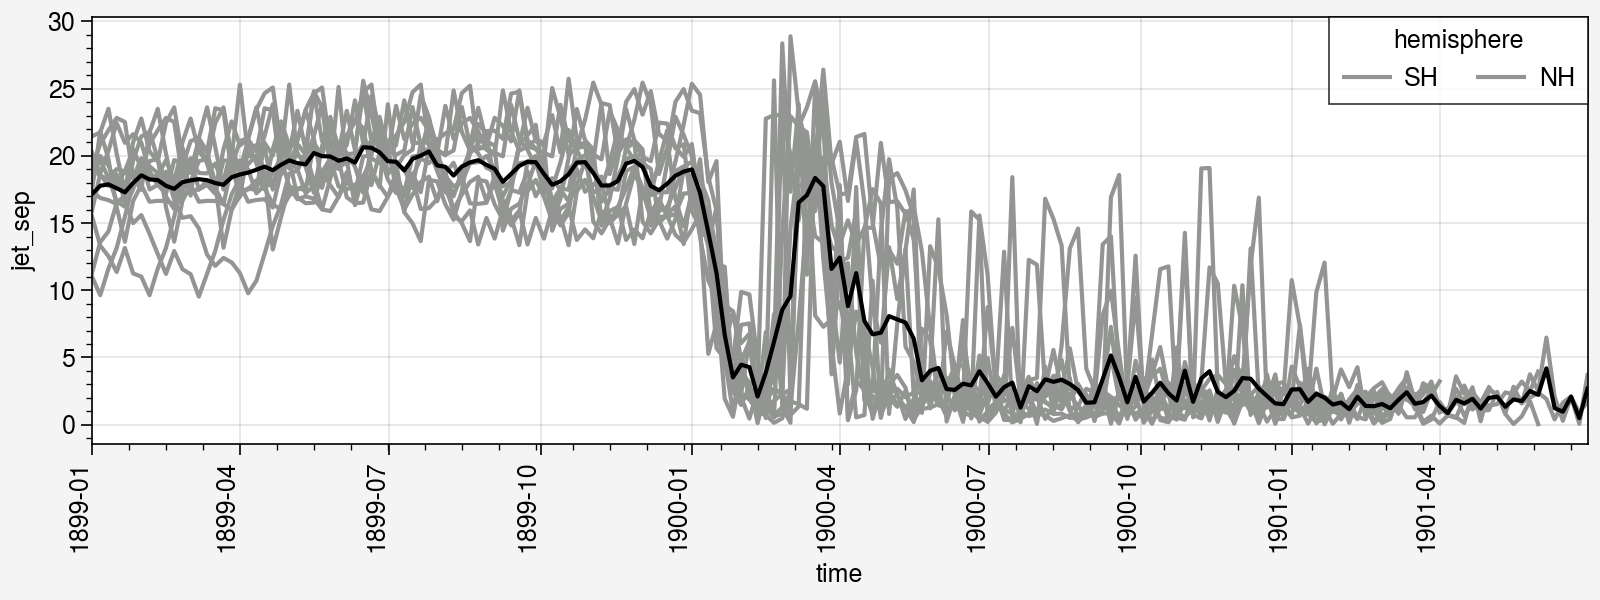

In [4]:
fig, ax = pplt.subplots(figsize=(8,3))

for exp_name in exp_names:
    ds_js.sel(exp_name=exp_name).jet_sep.plot.line(ax=ax, x='time', color='gray')
    
ds_js.mean(['exp_name', 'hemisphere']).jet_sep.plot.line(ax=ax, x='time', color='black')
fig.savefig(f'{series}_jet_separation.{plot_format}')

ValueError: Input shapes x (64,) and y (90,) must match z centers (64, 90) or z borders (65, 91).

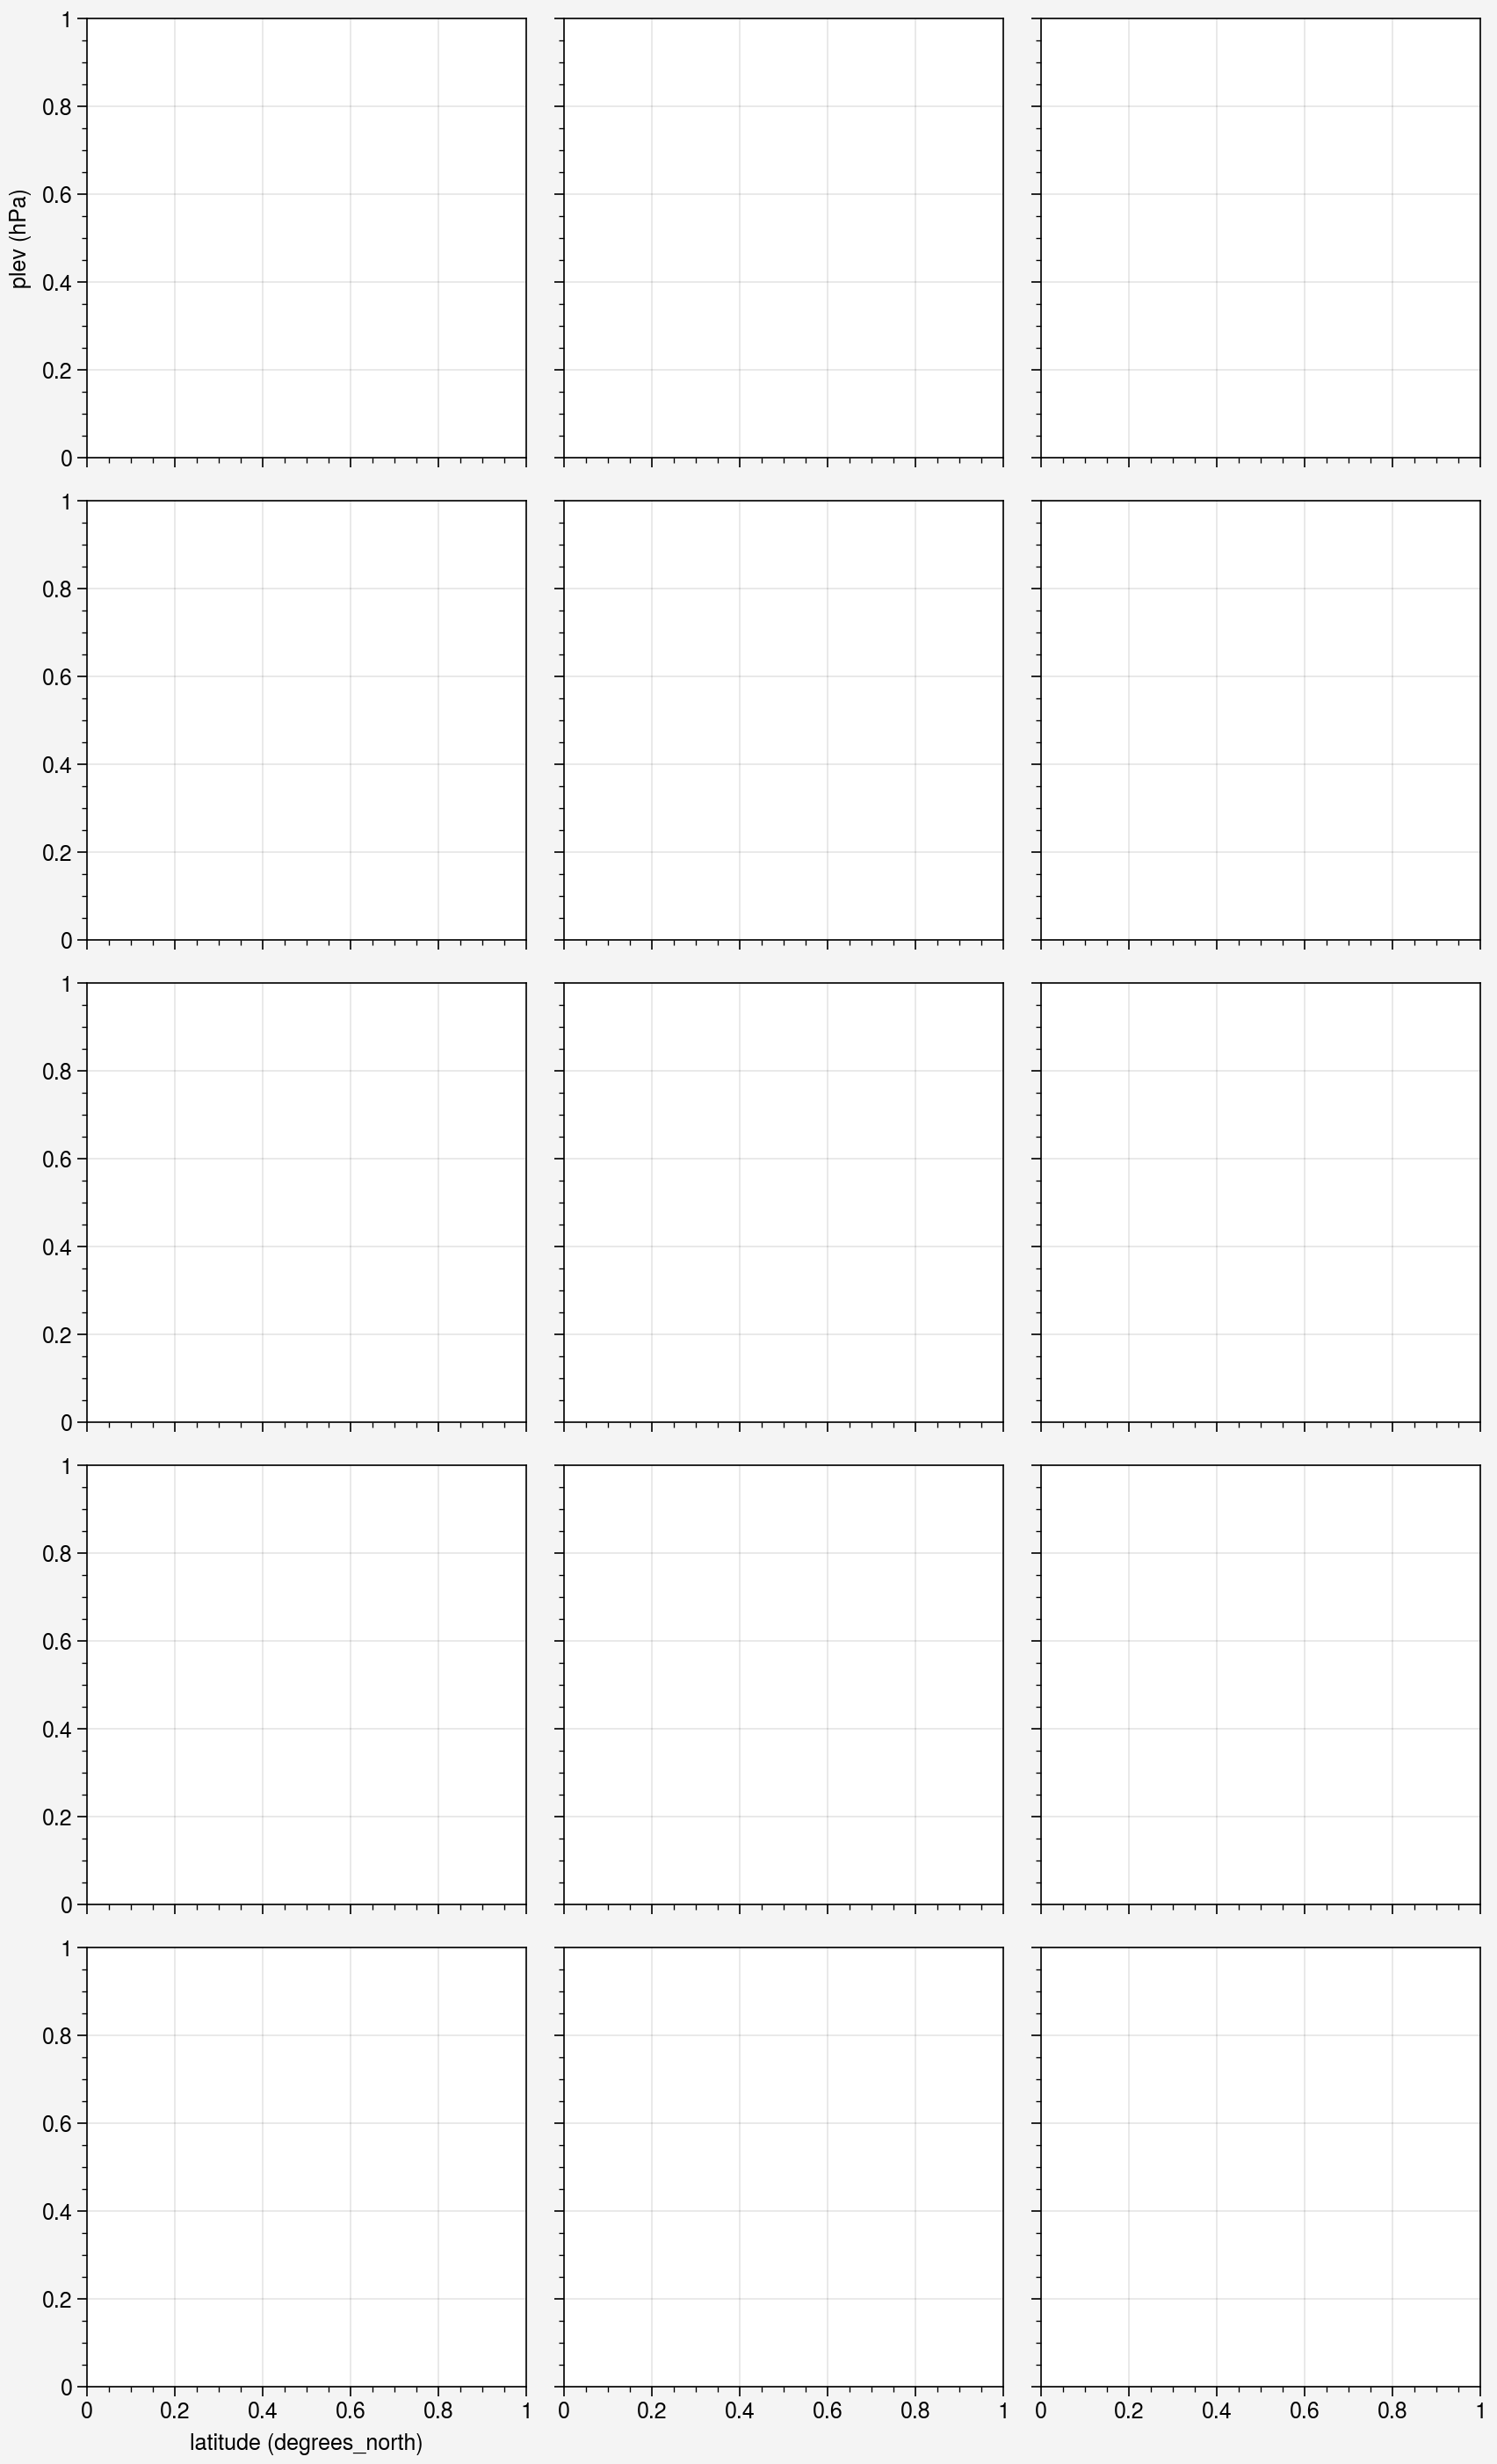

In [3]:
fig, ax = pplt.subplots(nrows=5, ncols=3)
coords = ['plev','lat','time']
ds = ds_ep.mean('exp_name')
ds_wind = ds_zm.mean('exp_name')
var = 'div1'

var_da = ds[var].transpose(*coords) * 24 * 3600

start_date = new_trans_date - np.timedelta64(30, 'D')
#dlevel = np.abs(ds[var].max() - ds[var].min())/16
levels = np.append(np.linspace(var_da.sel(plev=slice(0,700)).min()/3, var_da.sel(plev=slice(0,700)).min()/10, 10), 
                   np.linspace(var_da.sel(plev=slice(0,700)).max()/10, var_da.sel(plev=slice(0,700)).max()/3, 10))
wind_levels = np.arange(-24, 36.1, 7)

cf = ax[0].contourf(ds.lat, ds.plev, var_da.sel(time=slice('1899-10','1899-12')).mean('time'), levels=levels, cmap='RdBu', extend='both')

for i,a in enumerate(ax):
    date1 = start_date + np.timedelta64(i * 10, 'D')
    date2 = date1 + np.timedelta64(5, 'D')
    
    a.contour(ds_wind.lat, ds_wind.plev, ds_wind.um1.sel(time=slice(date1, date2)).mean('time').T, levels=wind_levels, color='black', linewidth=1)
    a.contourf(ds.lat, ds.plev, var_da.sel(time=slice(date1, date2)).mean('time'), levels=levels, cmap='RdBu', extend='both')
    test =  var_da.sel(time=slice(date1, date2)).mean('time')
    a.set_title(f'time frame: {date1} to {date2}')
    a.set_ylim([1000,10])
    
fig.colorbar(cf, label=var, loc='r', rows=(2,4))
fig.savefig(f'{series}_{var}_evolution_panels.{plot_format}')

## ensemble mean animation

MovieWriter ffmpeg unavailable; using Pillow instead.


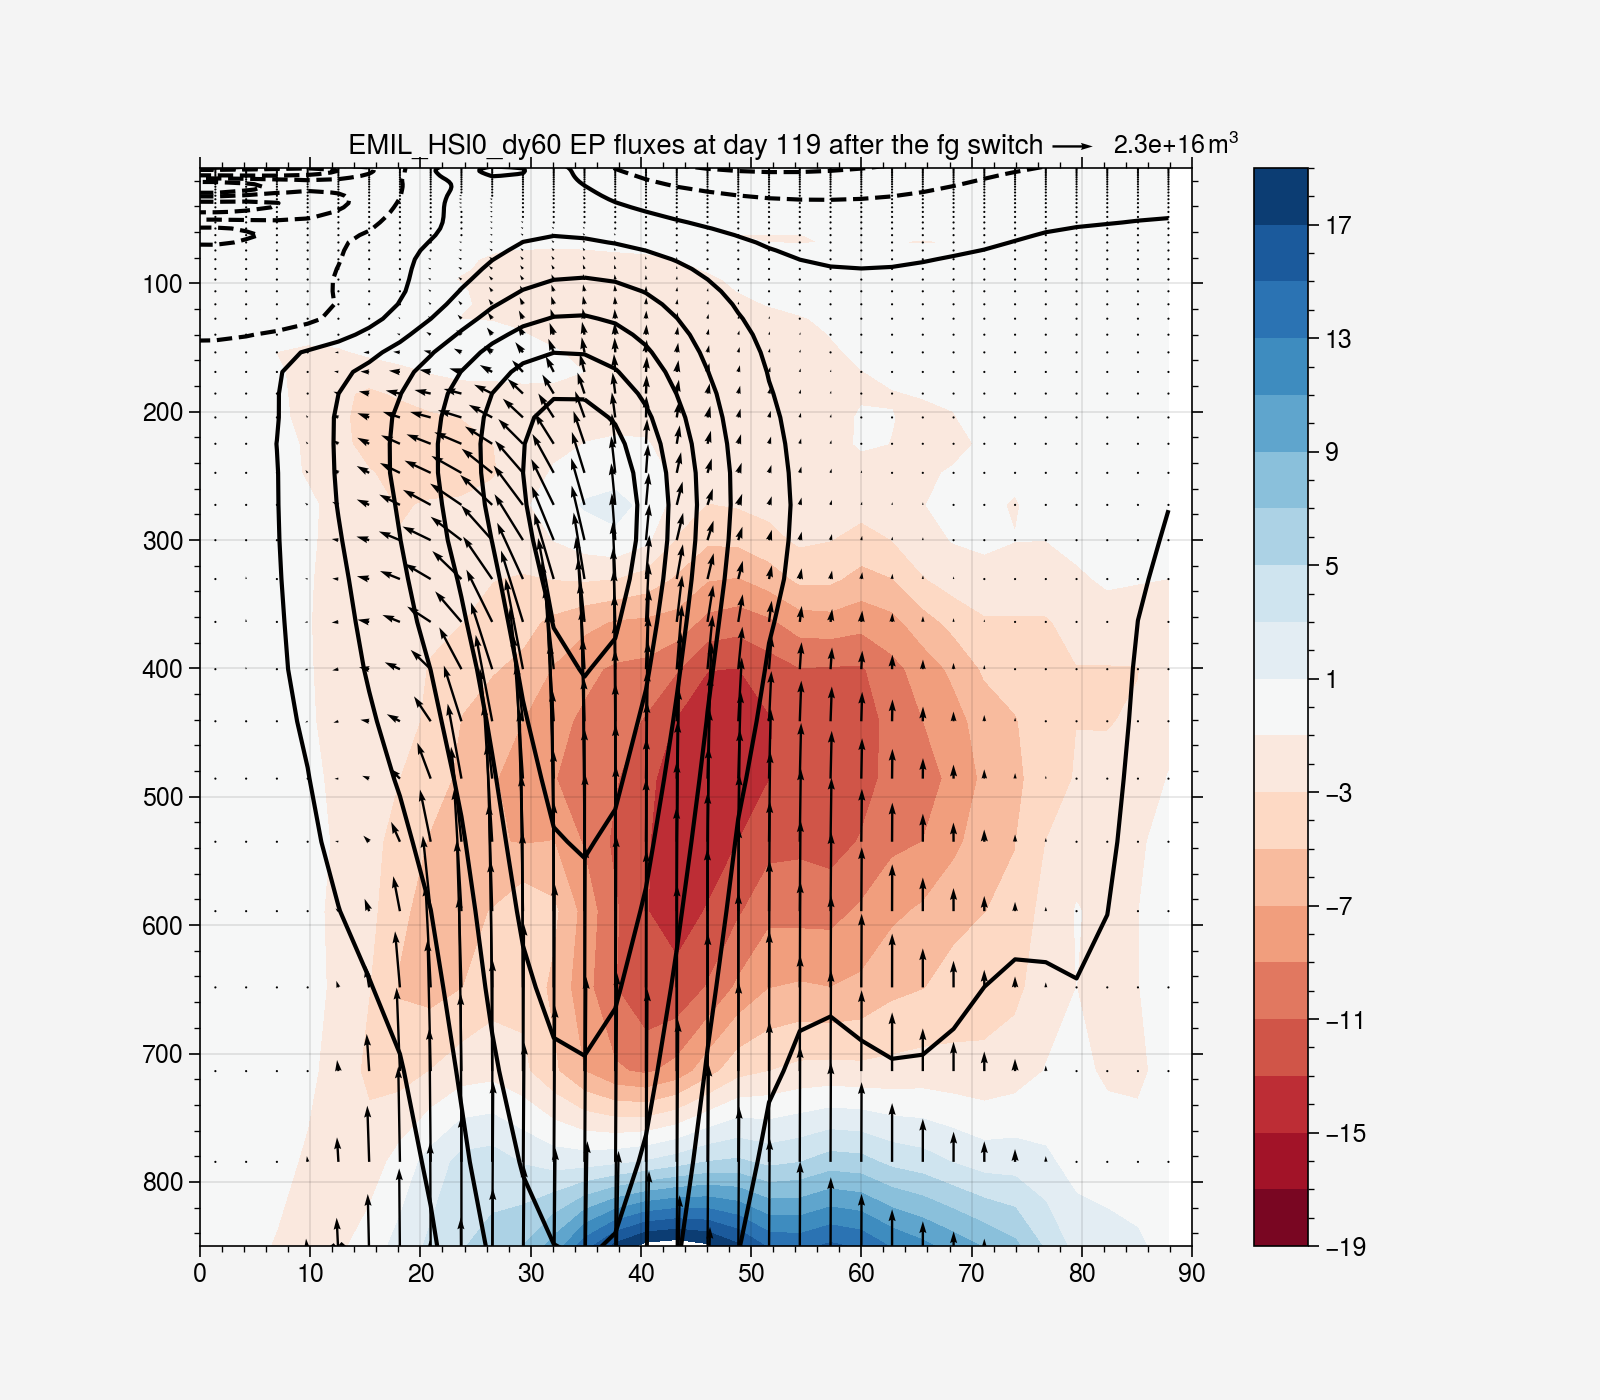

In [22]:
f = 5
n_days_before = 60
n_days_after = 120

trans_date = new_trans_date
start_date = trans_date - np.timedelta64(n_days_before, 'D')
end_date = trans_date + np.timedelta64(n_days_after, 'D')

ds = ds_ep.mean('exp_name').sel(lat=slice(90,-5), time=slice(start_date, end_date)).rolling(time=f, center=True, min_periods=1).mean('time')
ds_wind = ds_zm.mean('exp_name').sel(lat=slice(90,-5), time=slice(start_date, end_date)).rolling(time=f, center=True, min_periods=1).mean('time')

def animate_ep_flux(i, max_div=None):
    
    ax.clear()
    
    ds_sel = ds.isel(time=i)
    ds_wind_sel = ds_wind.isel(time=i)
    
    if max_div is None:
        max_div = np.ceil(np.abs((ds.div1+ds.div2)).sel(plev=slice(0,800)).max().values)
        #max_div += 0.3 * max_div
    d_level = np.round(max_div/10, 0)
    
    cf = ax.contourf(ds_sel.lat, ds_sel.plev, (ds_sel.div1+ds_sel.div2), levels=np.arange(-max_div,max_div + d_level, d_level), cmap='RdBu', extent='both')
    ax.contour(ds_wind_sel.lat, ds_wind_sel.plev, ds_wind_sel.um1.T, colors='black', levels=10)
    f_phi_dx, f_phi_dy = aostools.climate.PlotEPfluxArrows(ds_sel.lat.values, ds_sel.plev.values, ds_sel.ep_cart1, ds_sel.ep_cart2, fig, ax)
    
    ax.set_ylim([850,10])
    ax.set_xlim([0,90])
    ax.set_title(f'{ref_name} EP fluxes at day {- int(days_before_trans) + i} after the fg switch')
    
    return

fig, ax = plt.subplots(figsize=(8,7))
max_div = np.ceil(np.abs((ds.div1+ds.div2)).sel(plev=slice(0,800)).max().values)
d_level = np.round(max_div/10, 0)
days_before_trans = n_days_before # (ds_wind.trans_date.values - ds_wind.time[0].values).astype('timedelta64[D]')/np.timedelta64(1,'D')

cf = ax.contourf(ds.lat, ds.plev, (ds.div1+ds.div2).mean('time'), levels=np.arange(-max_div,max_div + d_level, d_level), cmap='RdBu', extent='both')
cbar = plt.colorbar(cf)

from matplotlib.animation import FuncAnimation

anime = FuncAnimation(
    fig=fig,
    func=animate_ep_flux,
    frames=n_days_before + n_days_after,
    interval=200,
)

anime.save(f'{series}_ep_evolution.gif')

# Old Code